In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [37]:
mobile_sales =  pd.read_excel('./content/mobilesales.xlsx')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


Preprocessing steps : 

- missing values
- clipping the values 
- set the datetime as index

<Axes: xlabel='DATE'>

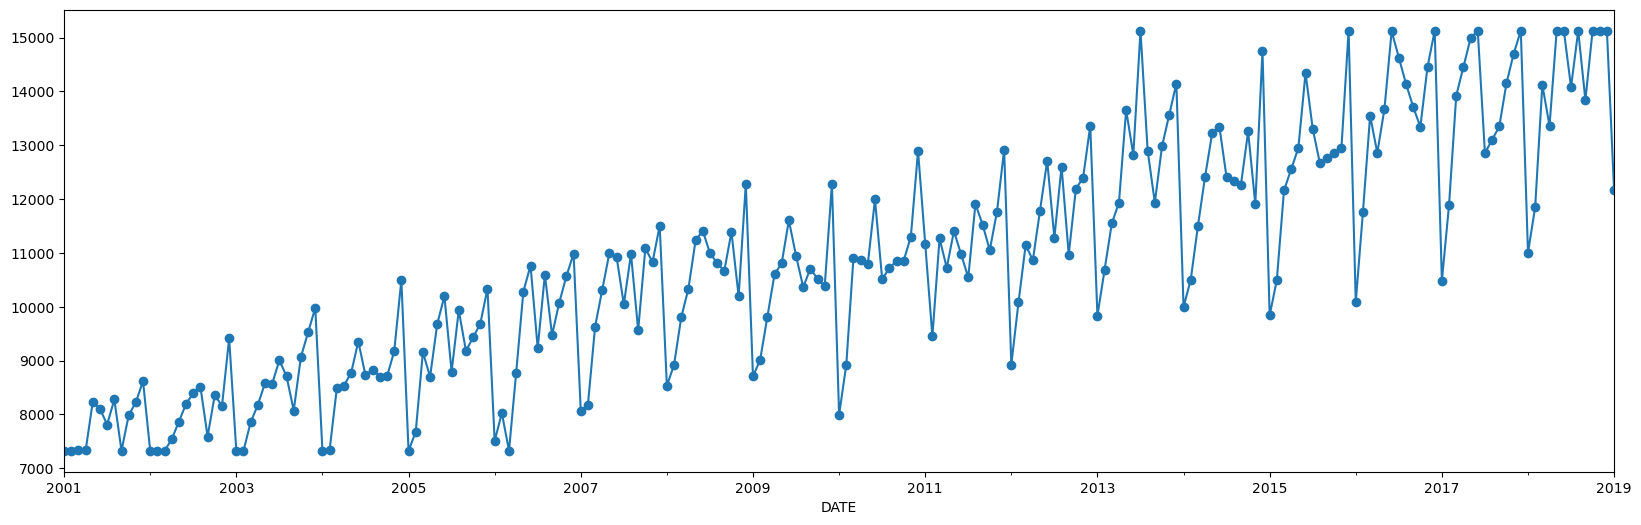

In [54]:
# linear interpolation
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))

# plot
mobile_sales.Sales.plot(style='-o', figsize=(20,6))

### Train - test splitting of data

In [62]:
time_max_index = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < time_max_index].copy()
test_x = mobile_sales.loc[mobile_sales.index >= time_max_index].copy()

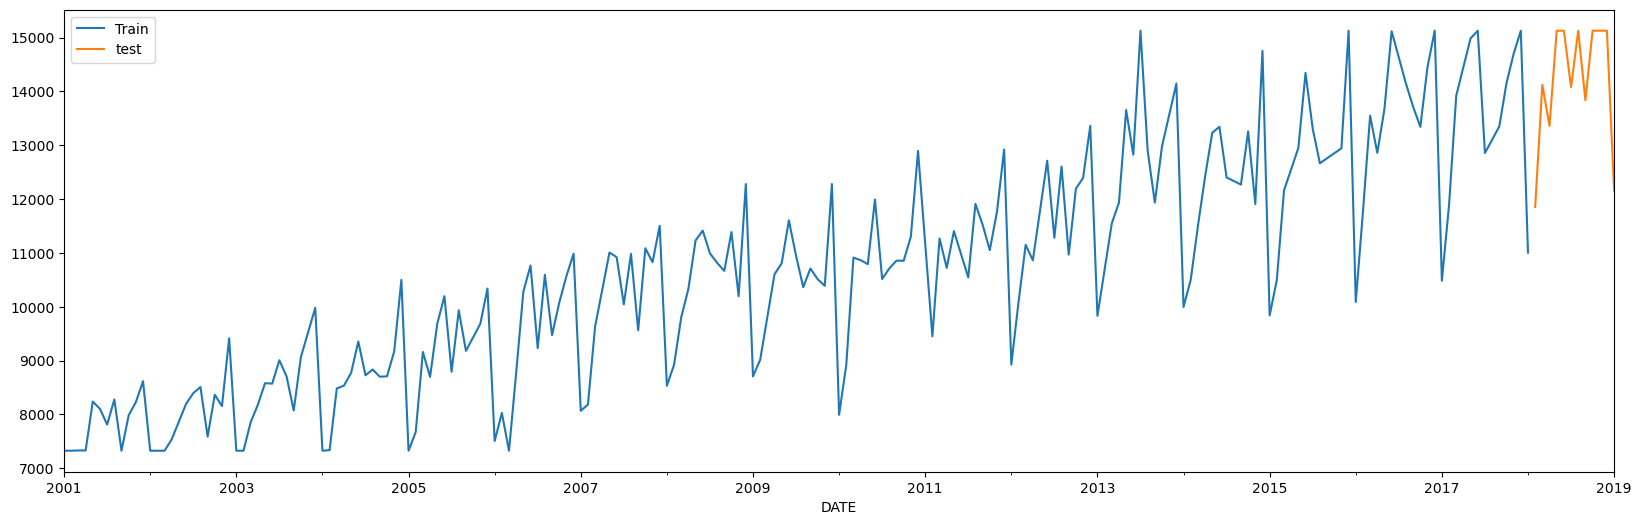

In [66]:
train_x.Sales.plot(label='Train')
test_x.Sales.plot(label = 'test')
plt.legend()

In [68]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

## Forcasting

#### Naive 
- Take the last value to predict

In [72]:
train_x.Sales[-1]

11005.0

MAE : 3176.41
RMSE : 3375.92
MAPE: 0.289


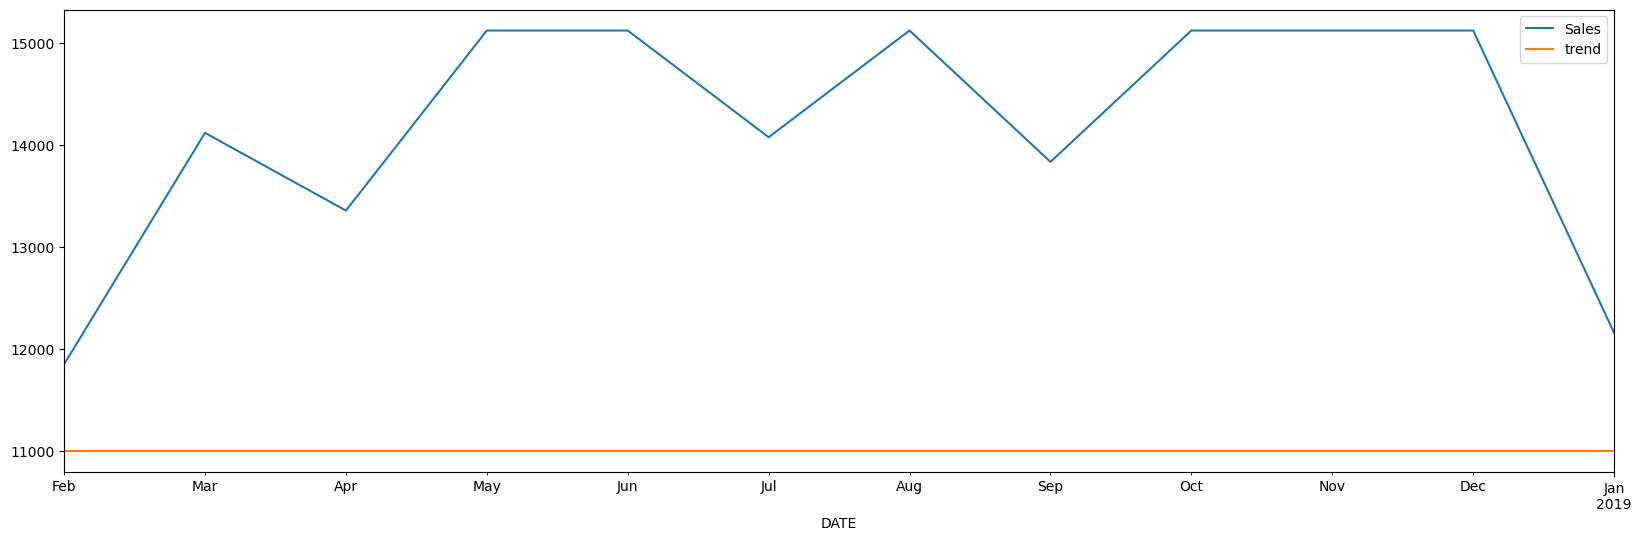

In [76]:
test_x['trend'] = train_x.Sales[-1]
test_x.plot()
performance(test_x['trend'], test_x['Sales'])

#### mean model
- take the mean value to predict 

In [78]:
train_x.Sales.mean()

10659.28956097561

MAE : 3522.12
RMSE : 3703.051
MAPE: 0.33


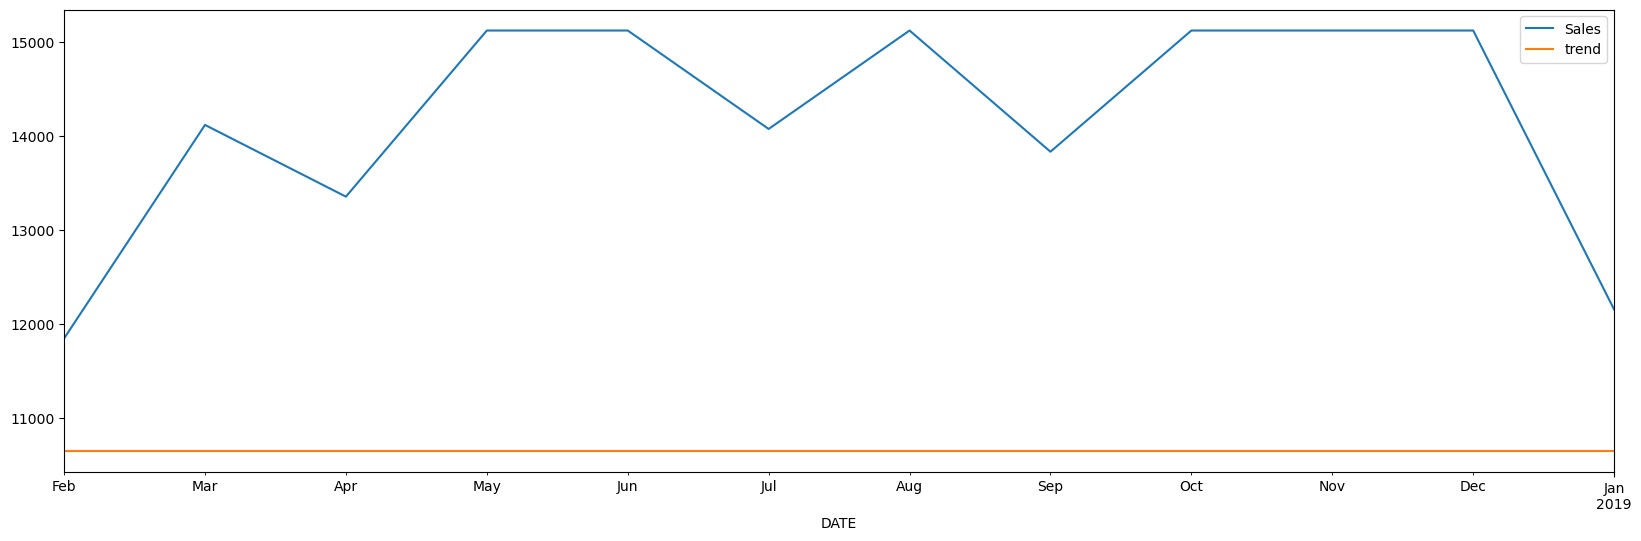

In [80]:
test_x['trend'] = train_x.Sales.mean()
test_x.plot()
performance(test_x['trend'], test_x['Sales'])

#### Seasonal Naive
- take the value of last season to predict

MAE : 647.94
RMSE : 892.969
MAPE: 0.049


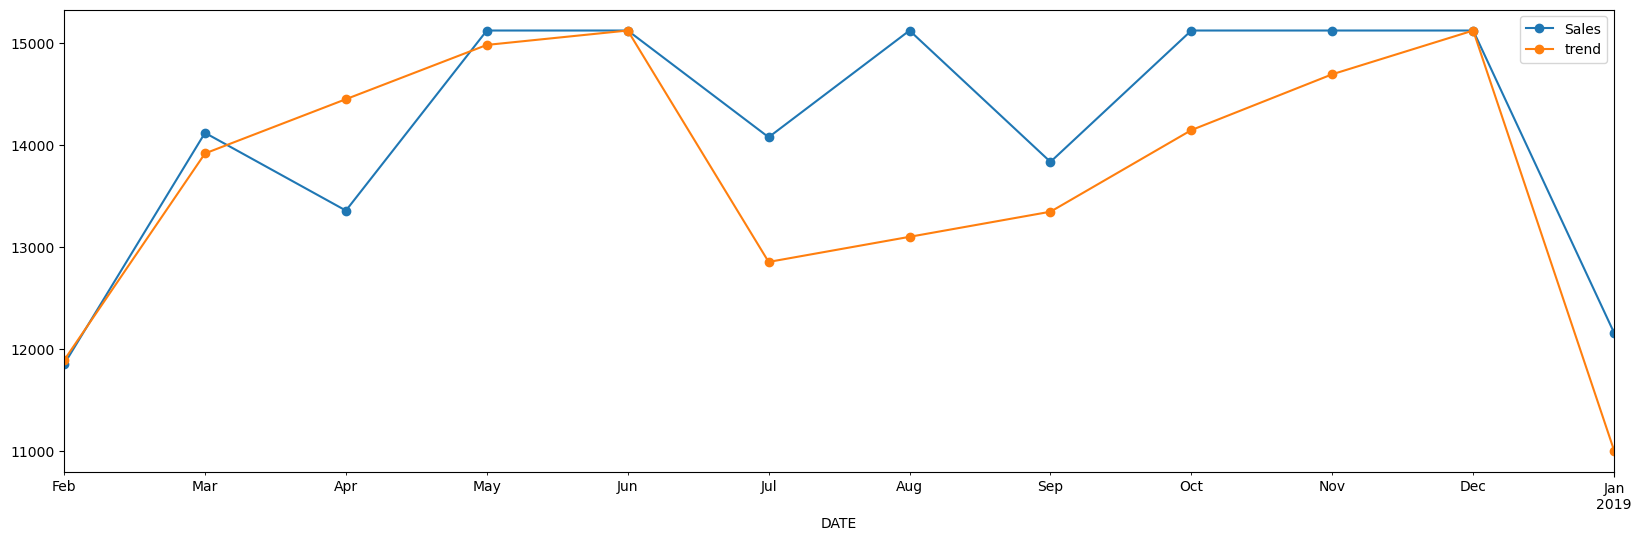

In [100]:
for idx in test_x.index:
    test_x.trend.loc[idx] =  train_x.loc[idx - pd.DateOffset(years=1)].Sales 
    
test_x.plot(style='-o')
performance(test_x['trend'], test_x['Sales'])

### Smoothing Based Methods

#### moving average 
- first we have to create the dates that we want to forcast
- and then take the average mean of last 3 points


In [212]:
df = mobile_sales.copy()

In [213]:
df.index[-1]
pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13 , freq='MS' )[1:])

""
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01
2019-11-01


In [214]:
df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13 , freq='MS')[1:]))
df.tail(20)

C:\Users\Upendra\AppData\Local\Temp\ipykernel_2952\443111647.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13 , freq='MS')[1:]))


,Sales
2018-06-01,15127.32
2018-07-01,14080.00
2018-08-01,15127.32
2018-09-01,13838.00
2018-10-01,15127.32
2018-11-01,15127.32
2018-12-01,15127.32
2019-01-01,12160.00
2019-02-01,NaN
2019-03-01,NaN


In [215]:
pred =  df.Sales.dropna().values
for idx in df.index[-12:]:
    pred = np.append(pred, pred[-3:].mean())

pred = pred.round(1)
pred[-20:]

array([15127.3, 14080. , 15127.3, 13838. , 15127.3, 15127.3, 15127.3,
       12160. , 14138.2, 13808.5, 13368.9, 13771.9, 13649.8, 13596.9,
       13672.8, 13639.8, 13636.5, 13649.7, 13642. , 13642.7])

<Axes: >

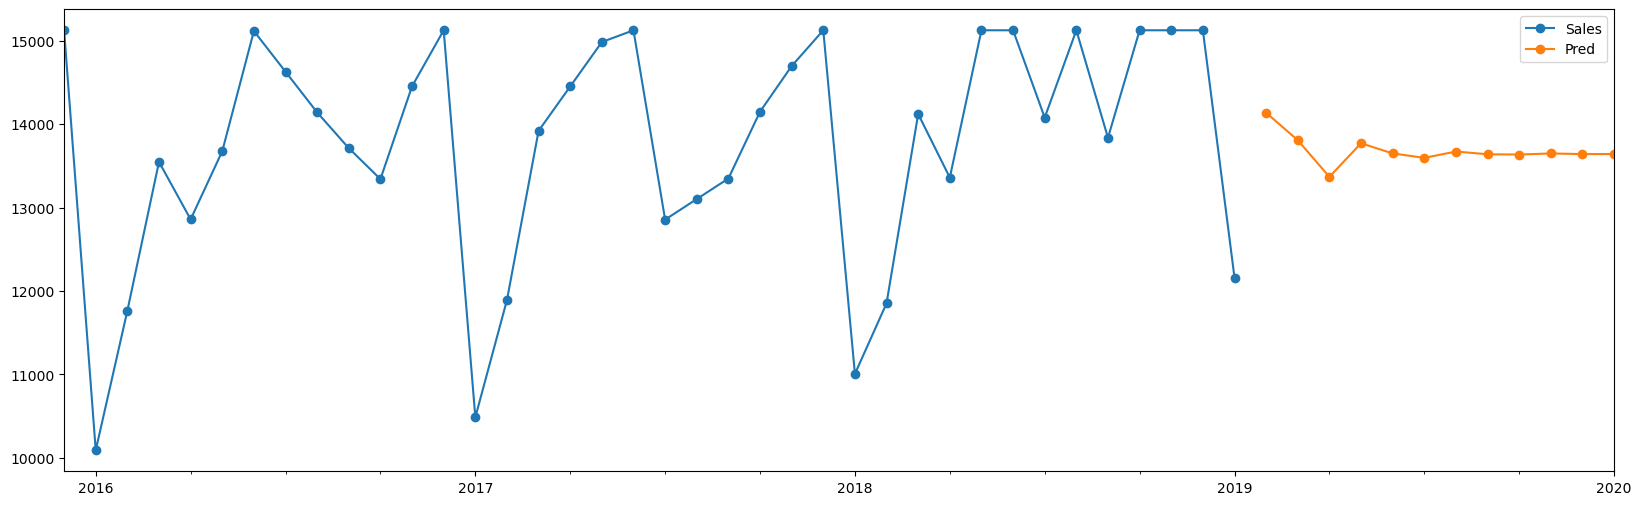

In [218]:
df['Pred'] = pred
df.loc[~df['Sales'].isna(), 'Pred'] = np.nan
df.tail(50).plot(style='-o')

* moving average does not take care of the seasonality

In [228]:
df = pd.DataFrame()
test_x = test_x.drop(columns=['trend'])

C:\Users\Upendra\AppData\Local\Temp\ipykernel_2952\1531913475.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS')[1:]))


MAE : 1565.501
RMSE : 1672.0
MAPE: 0.109


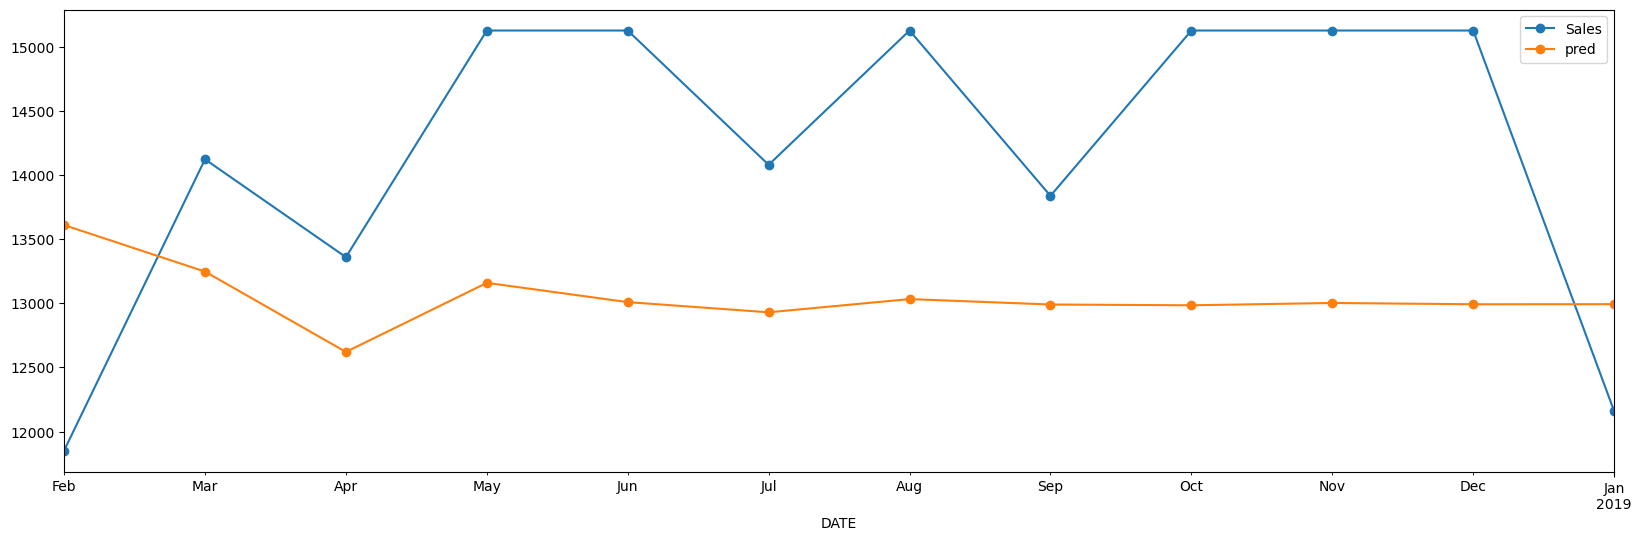

In [230]:
df = train_x.copy()

df = df.append(pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS')[1:]))

pred = df.Sales.dropna().values

for i in range(12):
    pred = np.append(pred, pred[-3:].mean())

test_x['pred'] = pred[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

As per MAPE, we can say that our model has 10.9% error.

This is much better than the other models we saw. Lets look at more models.

#### Simple exponential smoothing

In [231]:
import statsmodels.api as sm

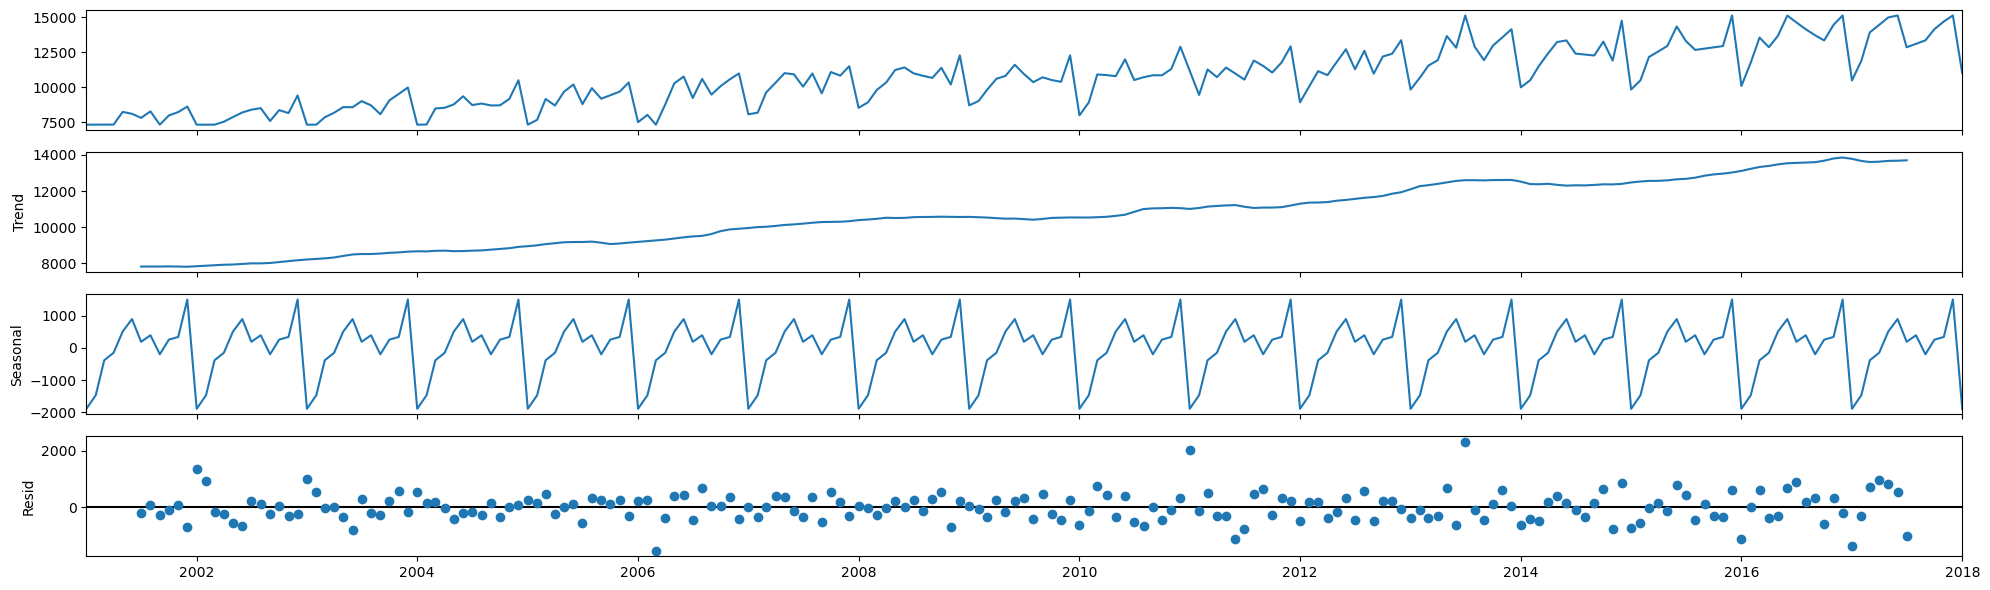

In [234]:
sm.tsa.seasonal_decompose(train_x).plot();

C:\Users\Upendra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [245]:
ses.forecast(12)

2019-02-01    14116.349847
2019-03-01    14116.349847
2019-04-01    14116.349847
2019-05-01    14116.349847
2019-06-01    14116.349847
2019-07-01    14116.349847
2019-08-01    14116.349847
2019-09-01    14116.349847
2019-10-01    14116.349847
2019-11-01    14116.349847
2019-12-01    14116.349847
2020-01-01    14116.349847
Freq: MS, dtype: float64

C:\Users\Upendra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Upendra\anaconda3\Lib\site-packages\pandas\util\_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


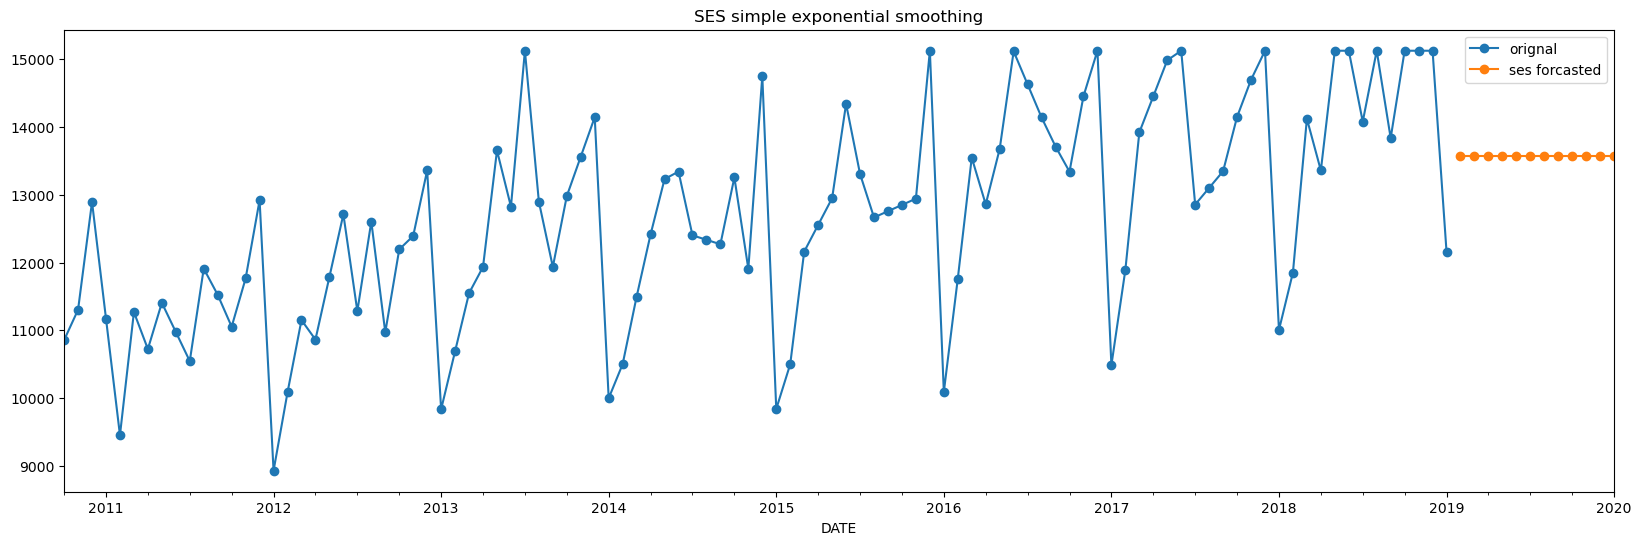

In [334]:
ses = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12))

mobile_sales.tail(100).Sales.plot(label='orignal', style='-o')
ses.forecast(steps=12).plot(label='ses forcasted', style='-o')
plt.title('SES simple exponential smoothing')
plt.legend()

C:\Users\Upendra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Upendra\anaconda3\Lib\site-packages\pandas\util\_decorators.py:211: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


MAE : 1410.497
RMSE : 1537.571
MAPE: 0.098


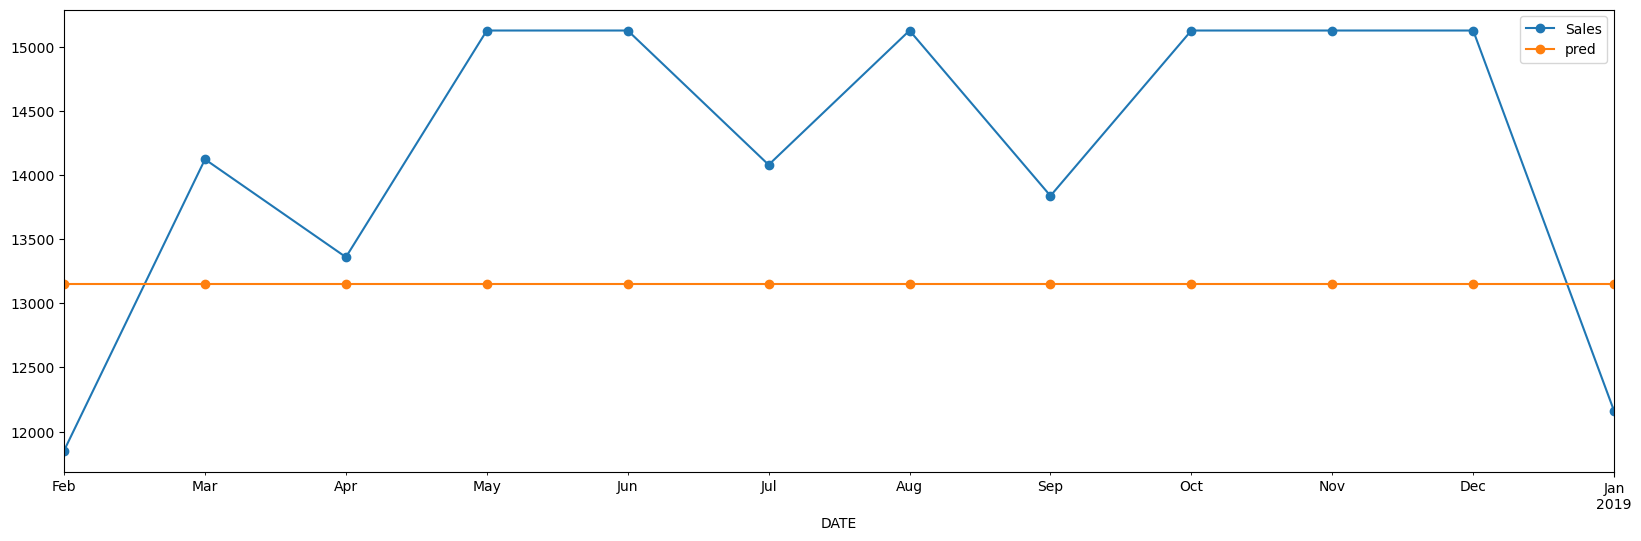

In [335]:
ses = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit(smoothing_level=1/(2*12))
test_x.pred =  ses.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x.pred)

As expected, the prediction is a straight line, but the erros is 10% which is less than the error of moving average.
So this model is performing better.
The SES Model is missing both

- trend, and
- seasonality

#### Double exponential smoothing

C:\Users\Upendra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Upendra\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


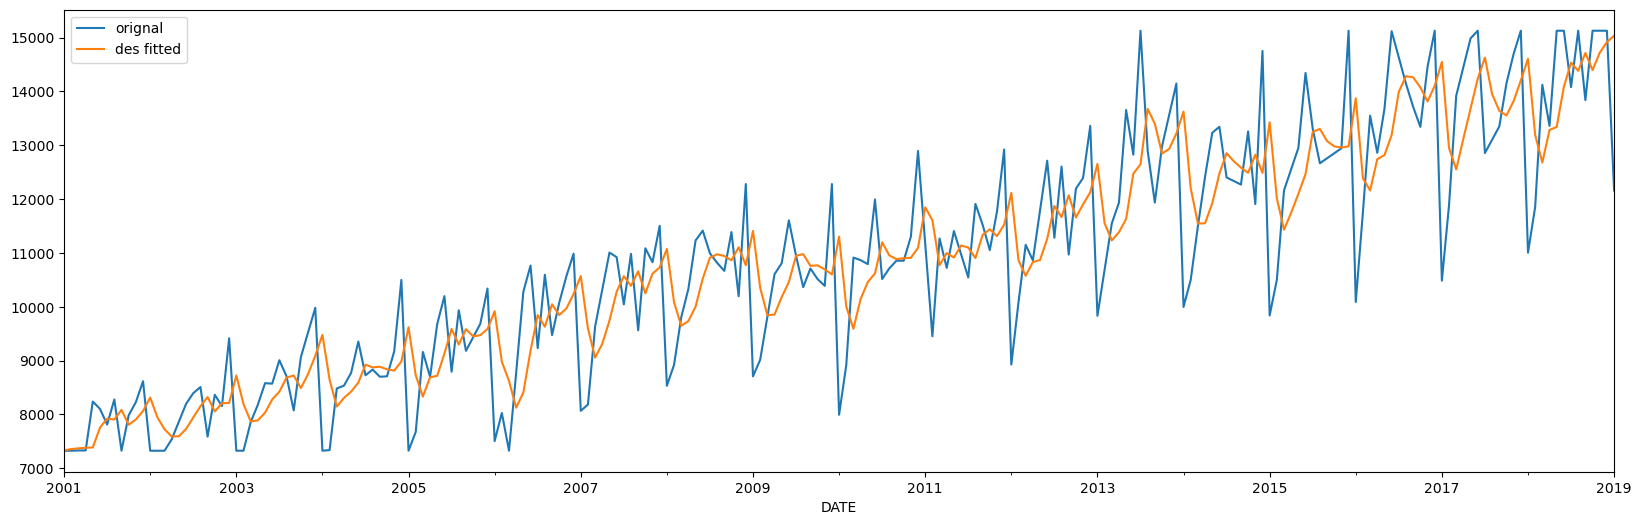

In [368]:
des = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add').fit(smoothing_level=0.4)

mobile_sales.Sales.plot(label='orignal',)
des.fittedvalues.plot(label='des fitted', )
plt.legend()

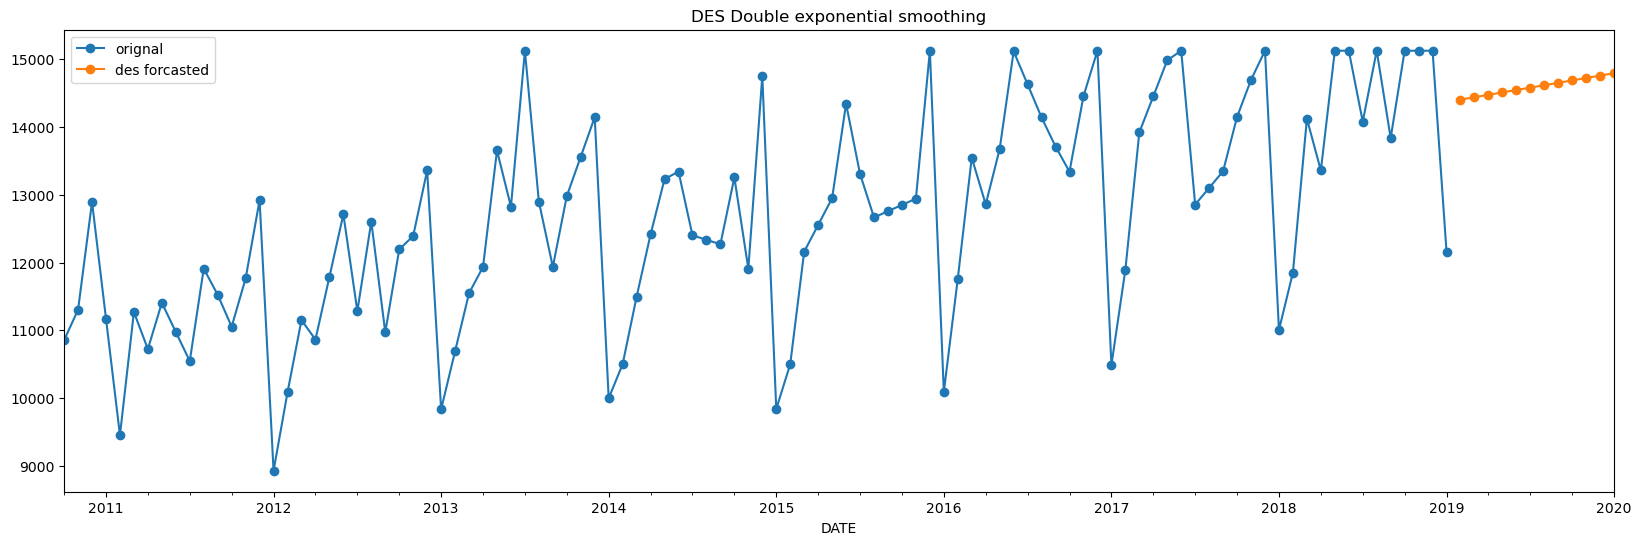

In [363]:
mobile_sales.tail(100).Sales.plot(label='orignal', style='-o')
des.forecast(steps=12).plot(label='des forcasted', style='-o')
plt.title('DES Double exponential smoothing')
plt.legend()
plt.show()

C:\Users\Upendra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 926.663
RMSE : 1122.104
MAPE: 0.068


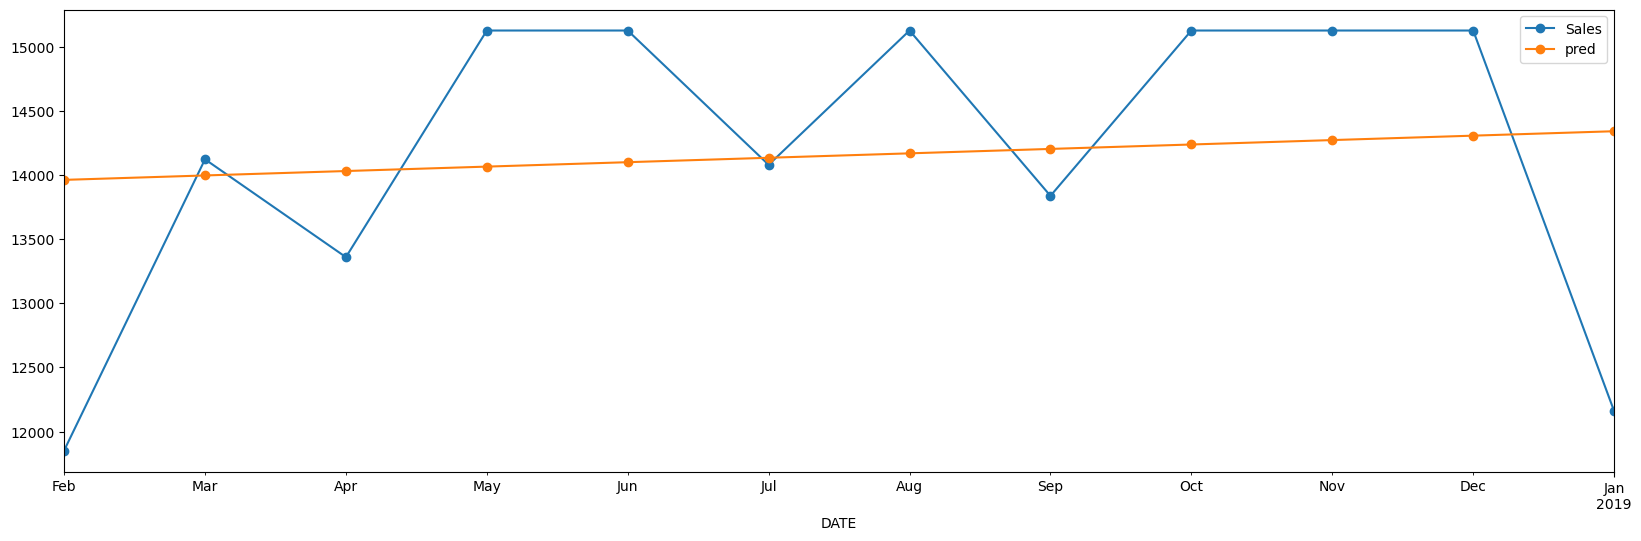

In [369]:
des = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit(smoothing_level=1/(2*12))
test_x.pred =  des.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x.pred)

#### Triple exponential smoothing

C:\Users\Upendra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


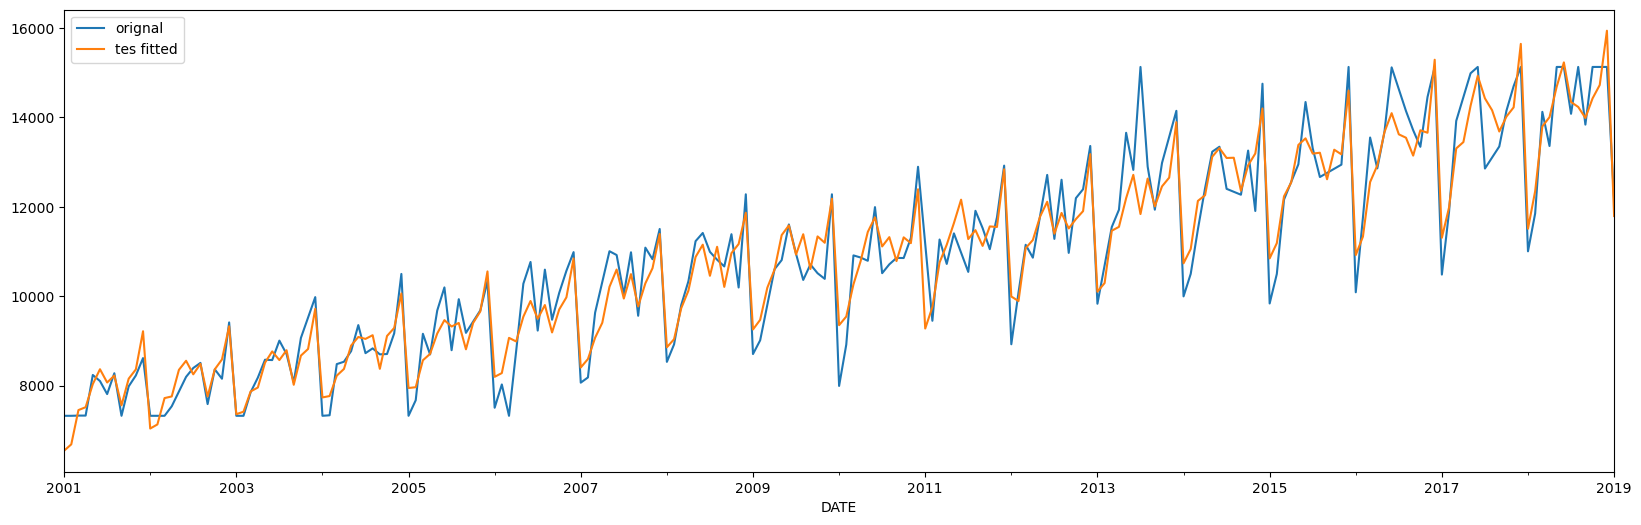

In [375]:
tes = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add', seasonal='add').fit(smoothing_level=1/(2*12))

mobile_sales.Sales.plot(label='orignal',)
tes.fittedvalues.plot(label='tes fitted', )
plt.legend()

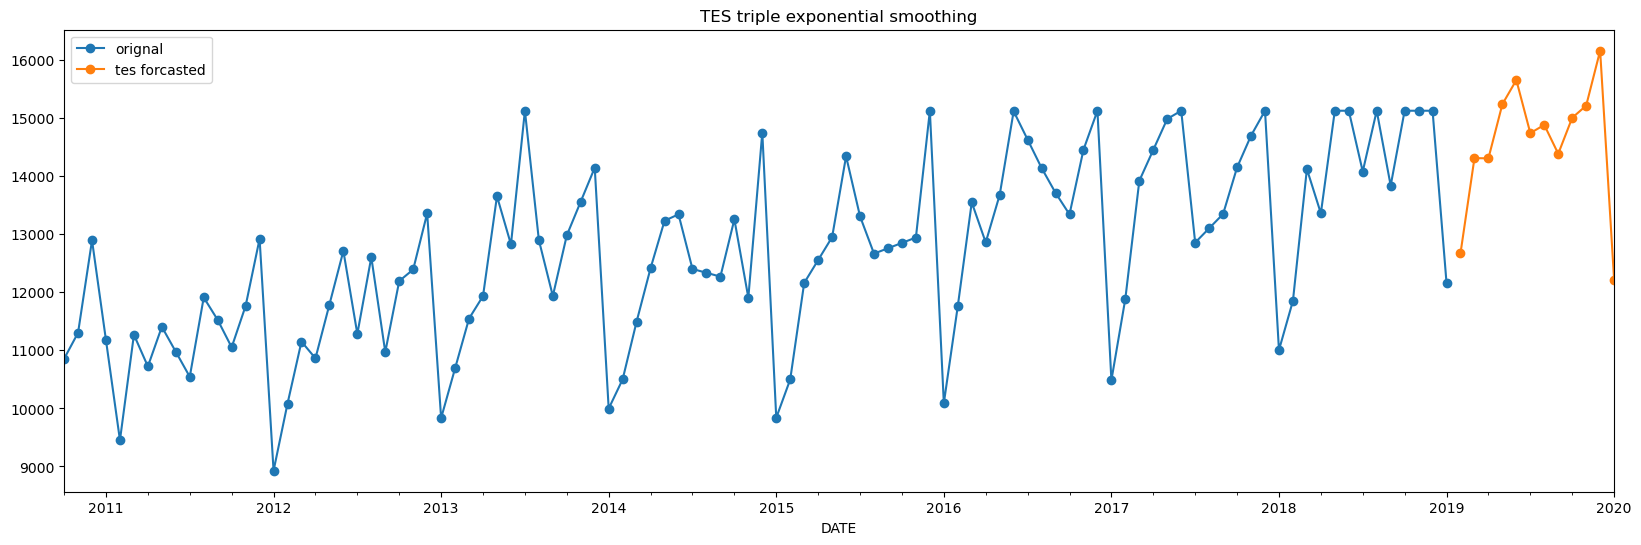

In [378]:
mobile_sales.tail(100).Sales.plot(label='orignal', style='-o')
tes.forecast(steps=12).plot(label='tes forcasted', style='-o')
plt.title('TES triple exponential smoothing')
plt.legend()
plt.show()

C:\Users\Upendra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 460.114
RMSE : 516.374
MAPE: 0.032


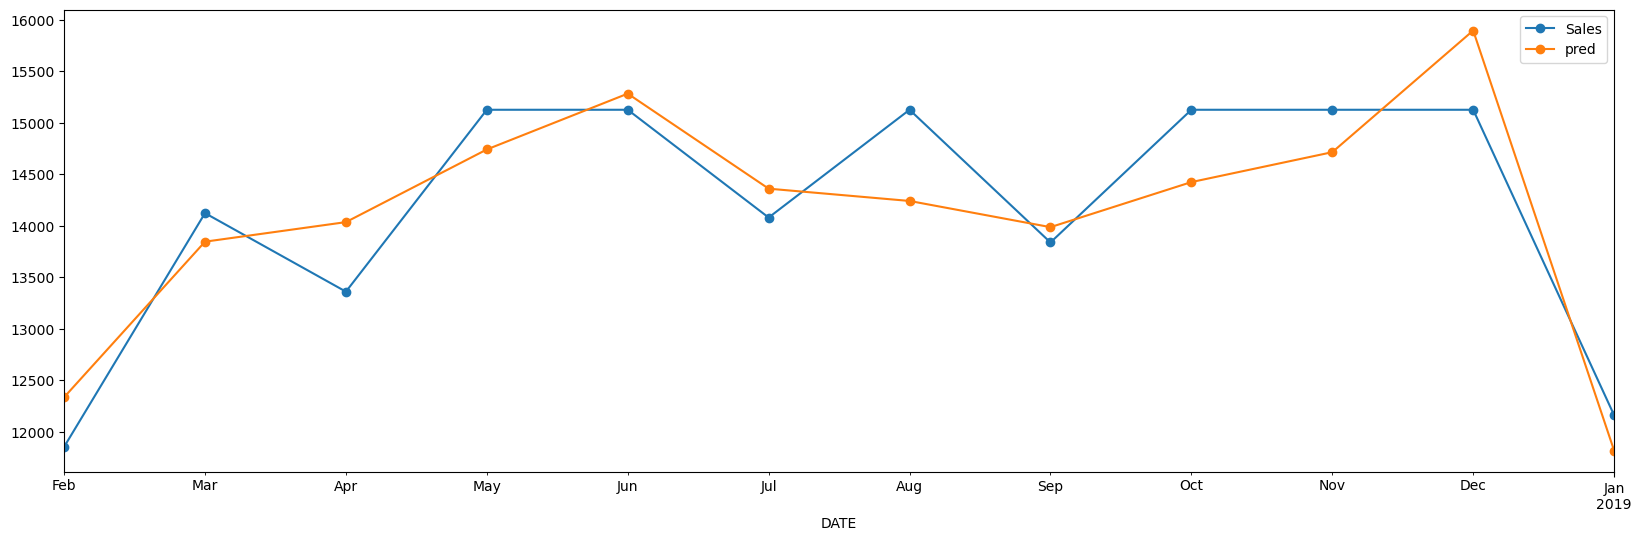

In [386]:
tes = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='add').fit(smoothing_level=1/(2*12))
test_x.pred = tes.forecast(steps=12)

test_x.plot(style='-o')
performance(test_x.Sales, test_x.pred)

Text(0.5, 1.0, 'des forcasted')

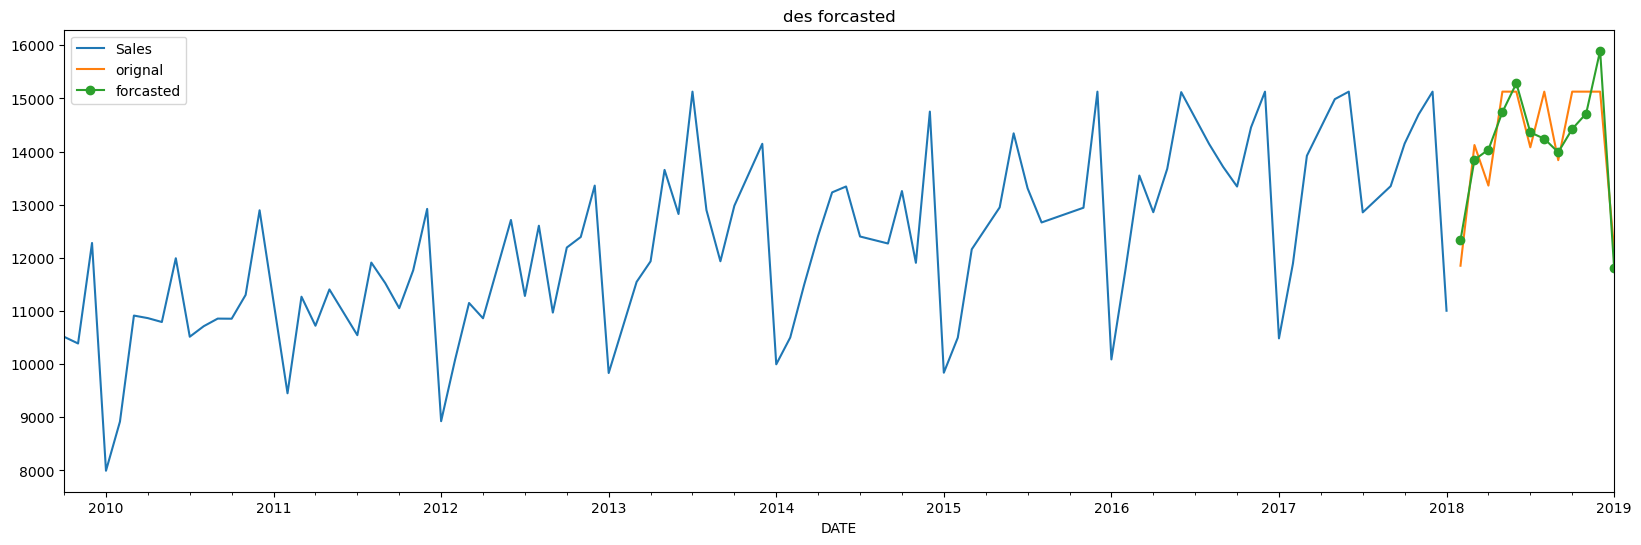

In [393]:
train_x.tail(100).Sales.plot()
test_x.Sales.plot(label='orignal')
test_x.pred.plot(label='forcasted', style='-o')
plt.legend()
plt.title('des forcasted')